In [33]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torchsummary
from torchsummary import summary
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
vgg16 = models.vgg16(pretrained=True)

In [3]:
def freeze_layers(model):
    for param in model.parameters():
        param.requires_grad = False

In [4]:
freeze_layers(vgg16)

In [5]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [6]:
data_dir = os.path.join('.', 'data')

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])

image_dataset = datasets.ImageFolder(data_dir, transform=data_transform)

dataloader = torch.utils.data.DataLoader(
        image_dataset, batch_size=32,
        shuffle=True, num_workers=4)

dataset_size = len(image_dataset)

print("Loaded images under {}".format(dataset_size))
    
print("Classes: ")
class_names = image_dataset.classes
print(image_dataset.classes)


Loaded images under 5539
Classes: 
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


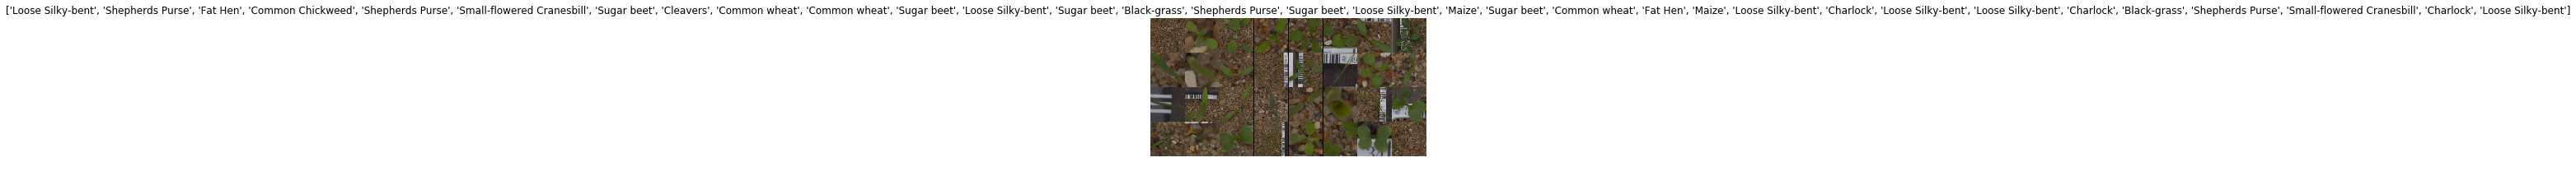

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader))
show_databatch(inputs, classes)

In [35]:
def sampleFromClass(ds, k):
    train_indices = []
    test_indices = []
    class_counts = {}
    
    for i in range(len(ds)):
        label_index = ds[i][1]
        class_counts[label_index] = class_counts.get(label_index, 0) + 1
        
        if class_counts[label_index] <= k:
            train_indices.append(i)
        else:
            test_indices.append(i)
    return train_indices, test_indices


In [36]:
train_indices, test_indices = sampleFromClass(image_dataset, int(252*.9))

In [37]:
train_ds = Subset(image_dataset, train_indices)
test_ds = Subset(image_dataset, test_indices)

In [38]:
train_ds

In [40]:
classes = {}
for a, b in train_ds:
    classes[b] = classes.get(b, 0) + 1
print(classes)

{0: 226, 1: 226, 2: 226, 3: 226, 4: 226, 5: 226, 6: 226, 7: 226, 8: 226, 9: 226, 10: 226, 11: 226}
